**Installing Kaggle to use kaggle dataset on Google Colab.**

In [1]:
!pip install tensorflow==2.15.0
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tsabitaputri","key":"9db4086319270a2abe487151ae2956a9"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nibinv23/iam-handwriting-word-database

Dataset URL: https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database
License(s): unknown
100% 1.10G/1.10G [01:06<00:00, 20.4MB/s]
100% 1.10G/1.10G [01:06<00:00, 17.8MB/s]


In [6]:
from zipfile import ZipFile
file_name = "iam-handwriting-word-database.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction Completed')

Extraction Completed


In [7]:
!pip install keras_tqdm

In [8]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from google.colab import drive

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

In [9]:
print(tf.__version__)

2.15.0


In [10]:
with open('/content/iam_words/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]
lines[0]

'#--- words.txt ---------------------------------------------------------------#'

In [11]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [12]:
images = []
labels = []
original_texts = []

RECORDS_COUNT = 10000

In [13]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [14]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    if w < 32:
        add_zeros = np.full((32 - w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128 - h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128, 32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    img = img / 255

    return img

**Generate Train and Validation**



In [15]:
for index, line in enumerate(lines):
    splits = line.strip().split(' ')
    if len(splits) < 9:
        continue

    status = splits[1]
    if status == 'ok':
        word_id, word = splits[0], "".join(splits[8:])
        filepath = f'/content/iam_words/words/{splits[0][:3]}/{splits[0][:7]}/{word_id}.png'
        
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue 

        img = process_image(img)
        label = encode_to_labels(word)

        images.append(img)
        labels.append(label)
        original_texts.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

In [16]:
# Split the data into training and validation sets (80% training, 20% validation)
train_images, valid_images, train_labels, valid_labels, train_original_texts, valid_original_texts = train_test_split(
    images, labels, original_texts, test_size=0.2, random_state=42
)

In [17]:
# Prepare the input lengths and label lengths
train_input_length = [31] * len(train_images)
train_label_length = [len(label) for label in train_labels]

valid_input_length = [31] * len(valid_images)
valid_label_length = [len(label) for label in valid_labels]

**Generate Padded label**

In [19]:
# Generate Padded label
train_padded_label = pad_sequences(train_labels, maxlen=max_label_len, padding='post', value=len(char_list))
valid_padded_label = pad_sequences(valid_labels, maxlen=max_label_len, padding='post', value=len(char_list))

In [20]:
train_padded_label.shape, valid_padded_label.shape

((25344, 19), (6337, 19))

**Convert to numpy array.**

In [21]:
# Convert to numpy array
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [22]:
train_images.shape

(25344, 32, 128, 1)

## **Model**


In [23]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
prediction_model = Model(inputs, outputs)

# model to be used at training time
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

train_model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 128, 64)          640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 64, 128)          73856     ['max_pooling2d[0][0]'] 

## **Train the Model**


In [24]:
batch_size = 8
epochs = 100
e = str(epochs)
optimizer_name = 'sgd'

In [25]:
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath="/content/best_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
callbacks_list = [checkpoint]

In [26]:
# Training the model
history = train_model.fit(
    x=[train_images, train_padded_label, train_input_length, train_label_length],
    y=np.zeros(len(train_images)),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], np.zeros(len(valid_images))),
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 10.09486, saving model to /content/best_model.h5
3168/3168 - 116s - loss: 12.3899 - accuracy: 0.0326 - val_loss: 10.0949 - val_accuracy: 0.0890 - 116s/epoch - 36ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 10.09486 to 5.26635, saving model to /content/best_model.h5
3168/3168 - 86s - loss: 7.4540 - accuracy: 0.1488 - val_loss: 5.2664 - val_accuracy: 0.2074 - 86s/epoch - 27ms/step
Epoch 3/100

Epoch 3: val_loss improved from 5.26635 to 4.04561, saving model to /content/best_model.h5
3168/3168 - 88s - loss: 4.2595 - accuracy: 0.2766 - val_loss: 4.0456 - val_accuracy: 0.3191 - 88s/epoch - 28ms/step
Epoch 4/100

Epoch 4: val_loss improved from 4.04561 to 3.34271, saving model to /content/best_model.h5
3168/3168 - 88s - loss: 3.0521 - accuracy: 0.3682 - val_loss: 3.3427 - val_accuracy: 0.3940 - 88s/epoch - 28ms/step
Epoch 5/100

Epoch 5: val_loss improved from 3.34271 to 2.69581, saving model to /content/best_model.h5
3168/3168 - 87s - loss: 2.3744 - accuracy: 0.4426 - val_loss: 2.6958 - val_accuracy: 0.4490 - 87s/epoch - 28ms/step
Epoch 6/100

Epoch 6: val_loss improved from 2.69581 to 2.55549, saving model to /content/best_model.h5
3168/3168 - 87s - loss: 1.8

## **Test the Model**


**Prediction.**

199/199 [==============================] - 5s 13ms/step
Original text: AN
Predicted text: AN


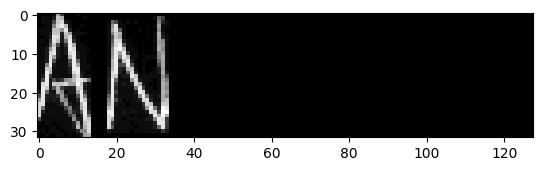

Original text: who
Predicted text: who


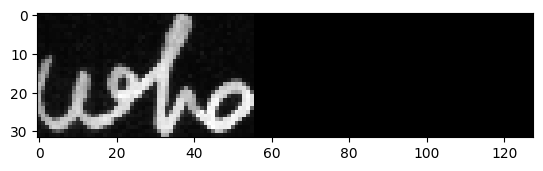

Original text: the
Predicted text: the


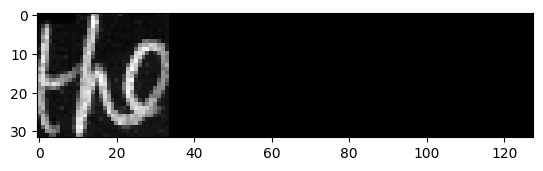

Original text: for
Predicted text: for


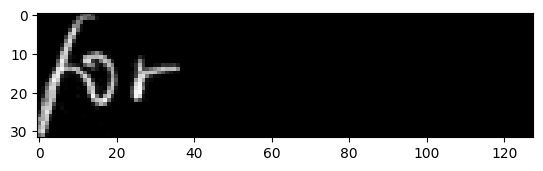

Original text: preserve
Predicted text: psesene


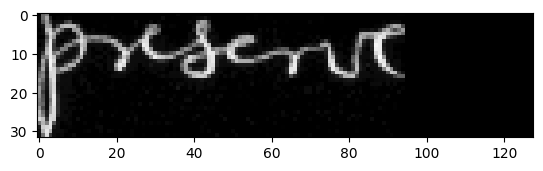

Original text: also
Predicted text: also


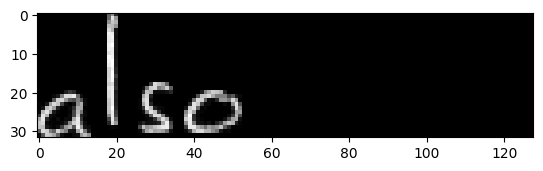

Original text: .
Predicted text: .


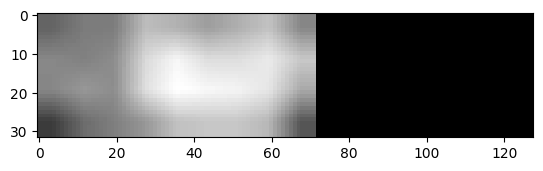

Original text: Commons
Predicted text: Commons


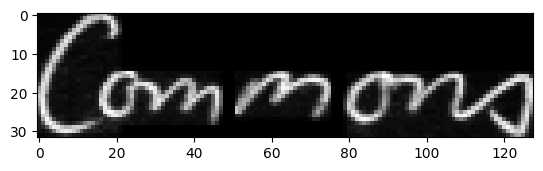

Original text: summoned
Predicted text: summoned


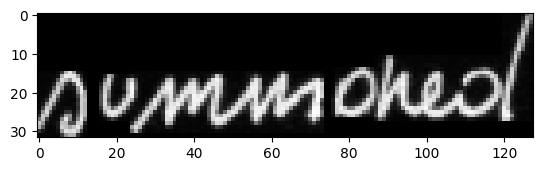

Original text: curb
Predicted text: curb


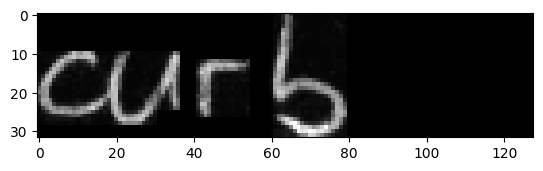

Original text: of
Predicted text: of


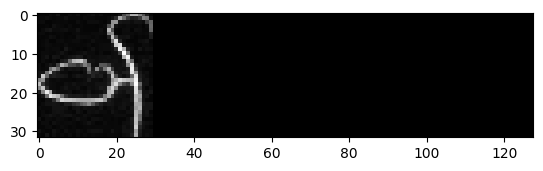

Original text: are
Predicted text: are


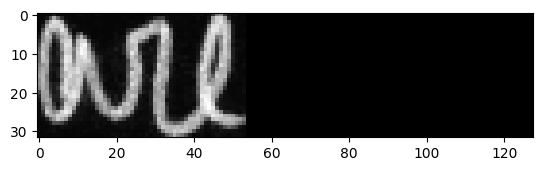

Original text: to
Predicted text: to


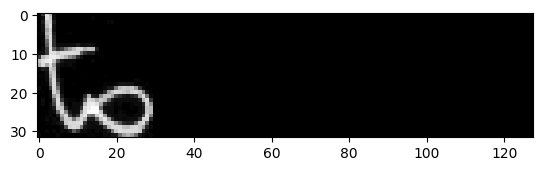

Original text: ,
Predicted text: ,


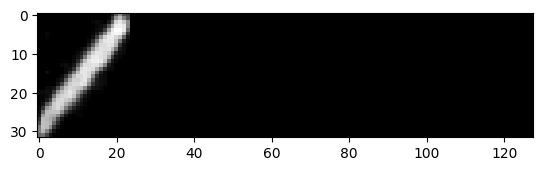

Original text: part
Predicted text: part


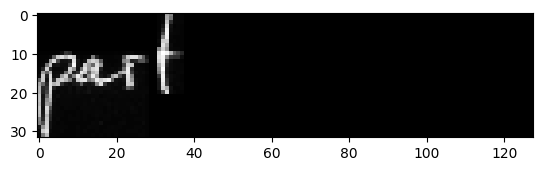

Original text: countries
Predicted text: countiles


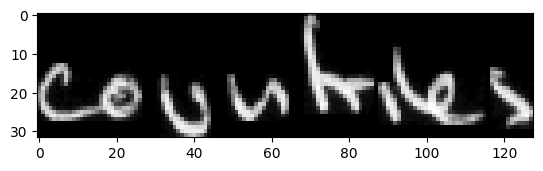

Original text: .
Predicted text: .


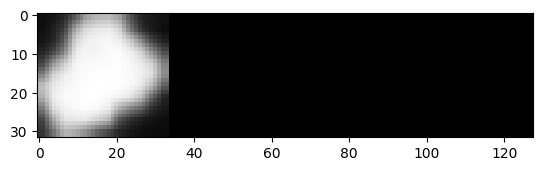

Original text: the
Predicted text: the


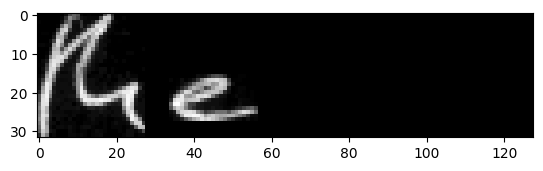

Original text: pharmaceutical
Predicted text: pharmacntical


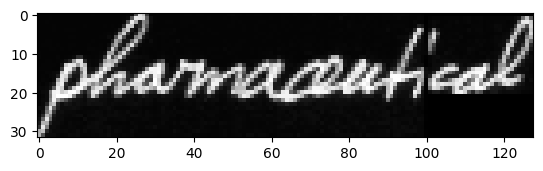

Original text: designed
Predicted text: acrigned


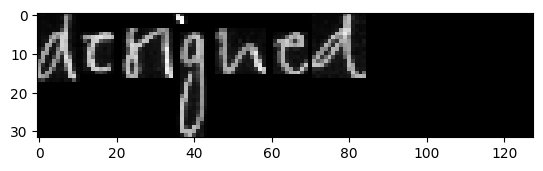

Original text: Vang
Predicted text: bary


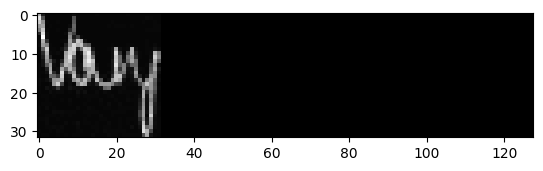

Original text: :
Predicted text: :


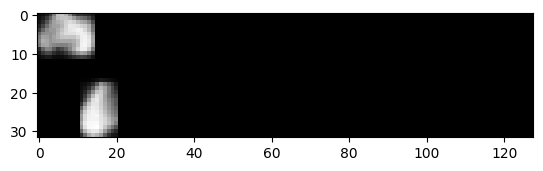

Original text: mystery
Predicted text: meyetory


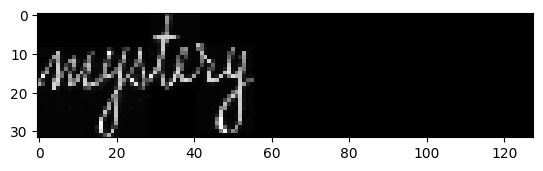

Original text: Like
Predicted text: whe


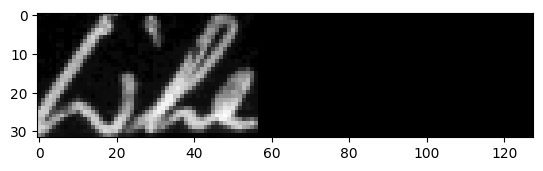

Original text: is
Predicted text: is


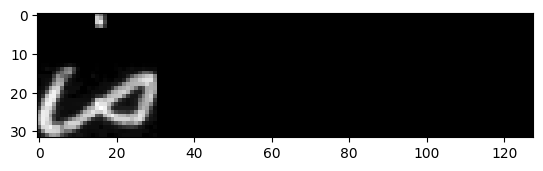

In [27]:
# Load the best weights into the prediction model
prediction_model.load_weights("/content/best_model.h5")

# Save the final prediction model
prediction_model.save("/content/Text-Recognition.h5")

# Predict and decode outputs on validation images
prediction = prediction_model.predict(valid_images)
decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
out = K.get_value(decoded)

max_iterations = 25
for i, x in enumerate(out[:25]):
    print("Original text:", valid_original_texts[i])
    print("Predicted text:", ''.join([char_list[int(p)] for p in x if int(p) != -1]))
    plt.imshow(valid_images[i].reshape(32, 128), cmap=plt.cm.gray)
    plt.show()

## **Plot Accuracy and Loss**

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

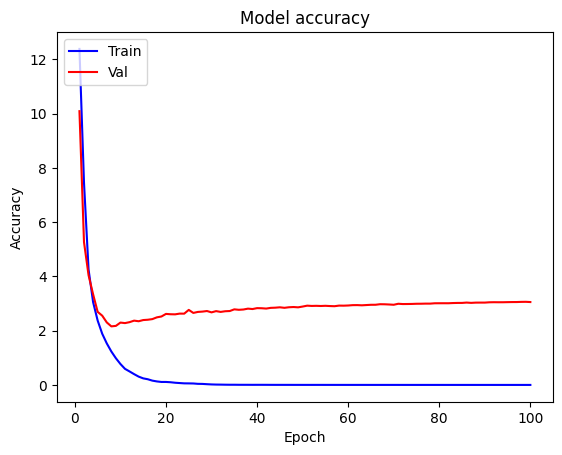

In [30]:
plotgraph(epochs, loss, val_loss)

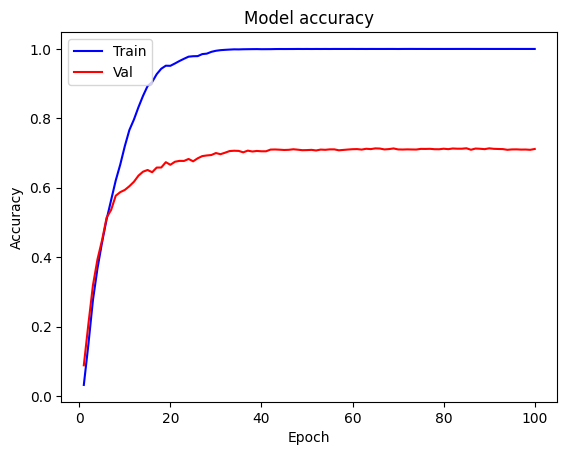

In [31]:
plotgraph(epochs, acc, val_acc)

## **Input testing**

In [32]:
from google.colab import files
from PIL import Image
import numpy as np
import cv2

In [33]:
uploaded = files.upload()

Saving testing9.jpeg to testing9.jpeg


In [ ]:
image_path = list(uploaded.keys())[0]

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
processed_image = process_image(image)

In [ ]:
plt.imshow(processed_image.reshape(32, 128), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
prediction = prediction_model.predict(processed_image.reshape(1, 32, 128, 1))

In [ ]:
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

In [40]:
predicted_text = ''
for p in out[0]:
    if int(p) != -1:
        predicted_text += char_list[int(p)]

print("Predicted text:", predicted_text)

Predicted text: Anat



## **Get Best Model**

In [41]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [42]:
with open('/content/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath,
                                                      optimizer_name,
                                                      str(RECORDS_COUNT),
                                                      e,
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]),
                                                      best_loss,
                                                      best_acc,
                                                      best_val_loss,
                                                      best_val_acc)
    f.write(new_data)

## **Save the Model.**

In [43]:
from google.colab import files

In [45]:
files.download('/content/Text-Recognition.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>